## Matching the Pion quasi-PDF to the PDF

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Font settings
font_config = {
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "font.serif": ["Times New Roman"],
}

from matplotlib import rcParams

rcParams.update(font_config)

# Figure size settings
fig_width = 6.75  # in inches, 2x as wide as APS column
gr = 1.618034333  # golden ratio
fig_size = (fig_width, fig_width / gr)

# Default plot axes for general plots
plt_axes = [0.15, 0.15, 0.8, 0.8]  # left, bottom, width, height
fs_p = {"fontsize": 16}  # font size of text, label, ticks
fs_small_p = {"fontsize": 14}  # small font size of text, label, ticks
ls_p = {"labelsize": 16}

# Errorbar plot settings
errorb = {
    "markersize": 5,
    "mfc": "none",
    "linestyle": "none",
    "capsize": 3,
    "elinewidth": 1,
}  # none

errorb_circle = {
    "marker": "o",
    "markersize": 5,
    "mfc": "none",
    "linestyle": "none",
    "capsize": 3,
    "elinewidth": 1.5,
}  # circle

def default_plot():
    """
    Create a default plot.
    
    Usage: fig, ax = default_plot()

    Returns:
        fig: matplotlib.figure.Figure
        ax: matplotlib.axes.Axes
    """
    fig = plt.figure(figsize=fig_size)
    ax = plt.axes()
    ax.tick_params(direction="in", top="on", right="on", **ls_p)
    ax.grid(linestyle=":")
    return fig, ax


### Plot of quasi-PDF

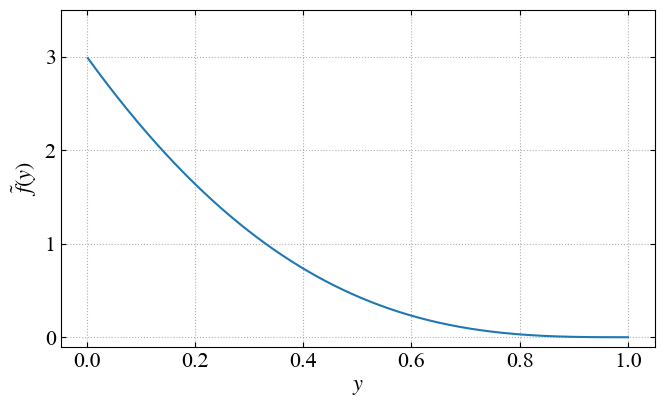

In [2]:
dy = 0.002 # discretization
quasi_y_ls = np.arange(dy, 1 + dy, dy)
# quasi_da = quasi_y_ls**(-0.1) * (1 - quasi_y_ls)
quasi_da = (quasi_y_ls + 3) * (1 - quasi_y_ls)**3

fig, ax = default_plot()
ax.plot(quasi_y_ls, quasi_da)
plt.xlabel(r"$y$", **fs_p)
plt.ylabel(r"$\tilde{f} (y)$", **fs_p)
plt.ylim(-0.1, 3.5)
plt.tight_layout()
plt.show()

### Fixed order lightcone PDF

x = 0.1 at  0.1
x = 0.3 at  0.3
x = 0.5 at  0.5
x = 0.6 at  0.6
lc_da at x=0.1 is  1.55908637340266
lc_da at x=0.3 is  0.5069129986103207
lc_da at x=0.5 is  0.24799051221980695
lc_da at x=0.6 is  0.16780533208184134


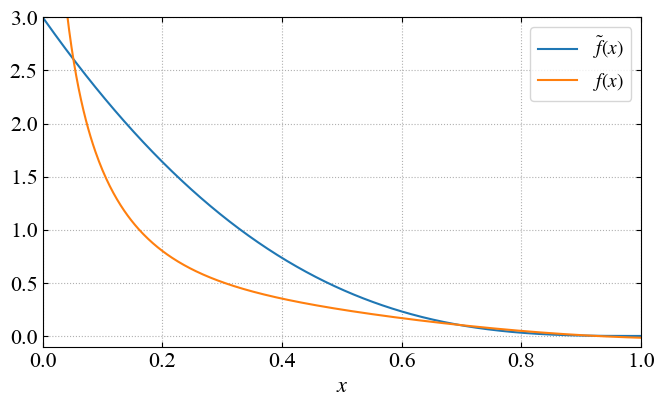

In [3]:
from utils import matching_fixed_order

lc_x_ls = quasi_y_ls
pz_gev = 2
mu = 2

lc_da = matching_fixed_order(quasi_da, lc_x_ls, quasi_y_ls, pz_gev, mu)

idx_x_01 = int(0.1 / dy) - 1
idx_x_03 = int(0.3 / dy) - 1
idx_x_05 = int(0.5 / dy) - 1
idx_x_06 = int(0.6 / dy) - 1

print("x = 0.1 at ", lc_x_ls[idx_x_01])
print("x = 0.3 at ", lc_x_ls[idx_x_03])
print("x = 0.5 at ", lc_x_ls[idx_x_05])
print("x = 0.6 at ", lc_x_ls[idx_x_06])

print("lc_da at x=0.1 is ", lc_da[idx_x_01])
print("lc_da at x=0.3 is ", lc_da[idx_x_03])
print("lc_da at x=0.5 is ", lc_da[idx_x_05])
print("lc_da at x=0.6 is ", lc_da[idx_x_06])


fig, ax = default_plot()
ax.plot(quasi_y_ls, quasi_da, label=r"$\tilde{f} (x)$")
ax.plot(lc_x_ls, lc_da, label=r"$f (x)$")
plt.ylim(-0.1, 3)
plt.xlim(0, 1)
plt.legend(**fs_small_p)
plt.xlabel(r"$x$", **fs_p)
plt.tight_layout()
plt.show()


In [4]:
from utils import DGLAP_kernel

x_ls = np.arange(dy, 1, dy)
v_ls = np.arange(dy, 1, dy)
mu = 2

DGLAP_matrix = DGLAP_kernel(x_ls, v_ls, mu)

idx_x_01 = int(0.1 / dy) - 1

print( np.sum( [DGLAP_matrix[i][idx_x_01] for i in range(len(v_ls))] ) )



5.329070518200751e-15


### RGR lightcone PDF

- Fixed-order match to 2 xN Pz, evolove to 2 GeV (append xN to f_list) and 2 xN-1 Pz (append xN to g_list);
- Fixed-order match to 2 xN-1 Pz, replace xN with g_list, then evolve to 2 GeV (append xN-1 to f_list) and 2 xN-2 Pz (append xN-1 to g_list);

In [5]:
from utils import DGLAP_evolution

mu_target = 2 # GeV
pz_gev = 2

f_array = np.zeros_like(lc_x_ls)
g_array = np.zeros_like(lc_x_ls)

for idx in range(len(lc_x_ls)-1, -1, -1):
    x_i = lc_x_ls[idx]
    x_i_next = lc_x_ls[idx - 1]
    
    mu_i = 2 * x_i * pz_gev
    mu_i_next = 2 * x_i_next * pz_gev
    
    lc_da_fixed_order = matching_fixed_order(quasi_da, lc_x_ls, quasi_y_ls, pz_gev, mu_i)
    
    lc_da_evo = np.concatenate( [lc_da_fixed_order[:idx+1], g_array[idx+1:]] )
    
    lc_da_evo_target = DGLAP_evolution(lc_x_ls, lc_da_evo, mu_i, mu_target)
    lc_da_evo_next = DGLAP_evolution(lc_x_ls, lc_da_evo, mu_i, mu_i_next)
    
    f_array[idx] = lc_da_evo_target[idx]
    g_array[idx] = lc_da_evo_next[idx]

import os
if not os.path.exists('dump'):
    os.makedirs('dump')
np.save(f'dump/pdf_rgr_{dy}.npy', f_array)


In [ ]:
# from utils import DGLAP_evolution

# mu_target = 2 # GeV
# pz_gev = 2

# f_array = np.zeros_like(lc_x_ls)
# g_array = np.zeros_like(lc_x_ls)

# idx = int(0.6 / dy) - 1

# for idx in range(len(lc_x_ls)-1, idx-1, -1):
#     x_i = lc_x_ls[idx]
#     x_i_next = lc_x_ls[idx - 1]
    
#     mu_i = 2 * x_i * pz_gev
#     mu_i_next = 2 * x_i_next * pz_gev
    
#     lc_da_fixed_order = matching_fixed_order(quasi_da, lc_x_ls, quasi_y_ls, pz_gev, mu_i)
    
#     lc_da_evo = np.concatenate( [lc_da_fixed_order[:idx+1], g_array[idx+1:]] )
    
#     lc_da_evo_target = DGLAP_evolution(lc_x_ls, lc_da_evo, mu_i, mu_target)
#     lc_da_evo_next = DGLAP_evolution(lc_x_ls, lc_da_evo, mu_i, mu_i_next)
    
#     f_array[idx] = lc_da_evo_target[idx]
#     g_array[idx] = lc_da_evo_next[idx]

# print(lc_x_ls[idx])
# print(f_array[idx])



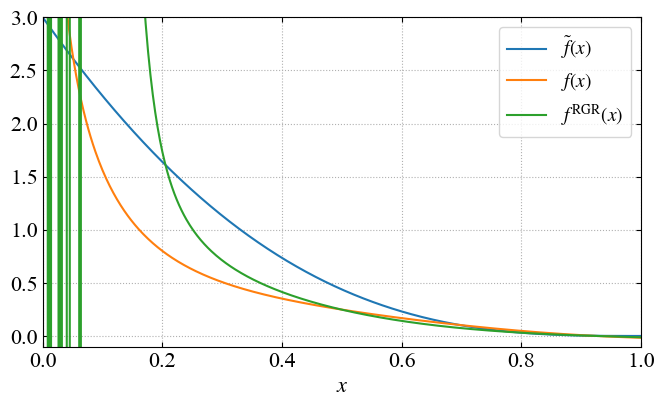

In [7]:

fig, ax = default_plot()
ax.plot(quasi_y_ls, quasi_da, label=r"$\tilde{f} (x)$")
ax.plot(lc_x_ls, lc_da, label=r"$f (x)$")
ax.plot(lc_x_ls, f_array, label=r"$f^{\rm RGR} (x)$")
plt.ylim(-0.1, 3)
plt.xlim(0, 1)
plt.legend(**fs_small_p)
plt.xlabel(r"$x$", **fs_p)
plt.tight_layout()
plt.savefig(f"plots/pdf_rgr_{dy}.pdf", transparent=True)
plt.show()

In [8]:
# Load the saved RGR PDF data
rgr_001_pdf = np.load('dump/pdf_rgr_0.01.npy')
rgr_0005_pdf = np.load('dump/pdf_rgr_0.005.npy')
rgr_0002_pdf = np.load('dump/pdf_rgr_0.002.npy')
rgr_0001_pdf = np.load('dump/pdf_rgr_0.001.npy')

print("\nf(x=0.4) in rgr_001_pdf is ", rgr_001_pdf[int(0.4 / 0.01) - 1])
print("f(x=0.4) in rgr_0005_pdf is ", rgr_0005_pdf[int(0.4 / 0.005) - 1])
print("f(x=0.4) in rgr_0002_pdf is ", rgr_0002_pdf[int(0.4 / 0.002) - 1])
print("f(x=0.4) in rgr_0001_pdf is ", rgr_0001_pdf[int(0.4 / 0.001) - 1])


print("\nf(x=0.5) in rgr_001_pdf is ", rgr_001_pdf[int(0.5 / 0.01) - 1])
print("f(x=0.5) in rgr_0005_pdf is ", rgr_0005_pdf[int(0.5 / 0.005) - 1])
print("f(x=0.5) in rgr_0002_pdf is ", rgr_0002_pdf[int(0.5 / 0.002) - 1])
print("f(x=0.5) in rgr_0001_pdf is ", rgr_0001_pdf[int(0.5 / 0.001) - 1])


print("\nf(x=0.6) in rgr_001_pdf is ", rgr_001_pdf[int(0.6 / 0.01) - 1])
print("f(x=0.6) in rgr_0005_pdf is ", rgr_0005_pdf[int(0.6 / 0.005) - 1])
print("f(x=0.6) in rgr_0002_pdf is ", rgr_0002_pdf[int(0.6 / 0.002) - 1])
print("f(x=0.6) in rgr_0001_pdf is ", rgr_0001_pdf[int(0.6 / 0.001) - 1])




f(x=0.4) in rgr_001_pdf is  0.3982197278955867
f(x=0.4) in rgr_0005_pdf is  0.4024636798642931
f(x=0.4) in rgr_0002_pdf is  0.41360958242244106
f(x=0.4) in rgr_0001_pdf is  0.4252778662974922

f(x=0.5) in rgr_001_pdf is  0.2531512187114601
f(x=0.5) in rgr_0005_pdf is  0.24967274462705405
f(x=0.5) in rgr_0002_pdf is  0.24740283528443327
f(x=0.5) in rgr_0001_pdf is  0.24694728234630373

f(x=0.6) in rgr_001_pdf is  0.14978868645761054
f(x=0.6) in rgr_0005_pdf is  0.14560256413256345
f(x=0.6) in rgr_0002_pdf is  0.1415663796163358
f(x=0.6) in rgr_0001_pdf is  0.13939683379140266


In [9]:
# f(x=0.4) in rgr_001_pdf is  0.3985032646660636
# f(x=0.4) in rgr_0005_pdf is  0.4028847896962276
# f(x=0.4) in rgr_0001_pdf is  0.426105063882033

# f(x=0.5) in rgr_001_pdf is  0.25313238082696354
# f(x=0.5) in rgr_0005_pdf is  0.24966130685930138
# f(x=0.5) in rgr_0001_pdf is  0.24694397714382246

# f(x=0.6) in rgr_001_pdf is  0.1496863658660111
# f(x=0.6) in rgr_0005_pdf is  0.14548690278153553
# f(x=0.6) in rgr_0001_pdf is  0.13925280162805545

In [10]:
# quasi_da = (quasi_y_ls + 3) * (1 - quasi_y_ls)**3

# dx = 0.0001
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5308007551353662
# lc_da at x=0.3 is  0.5014851082487854
# lc_da at x=0.5 is  0.24642873427779302


# dx = 0.0005
# kernel NLO at x=0.5 is  4.486963620504419
# kernel complete at x=0.5 is  8.973927241008838
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5371656959850446
# lc_da at x=0.3 is  0.5027367817785069
# lc_da at x=0.5 is  0.24681742400780565


# dx = 0.001
# kernel NLO at x=0.5 is  3.74040539498256
# kernel complete at x=0.5 is  7.48081078996512
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5447104293355987
# lc_da at x=0.3 is  0.504233344612122
# lc_da at x=0.5 is  0.24728712458513702


# dx = 0.005
# kernel NLO at x=0.5 is  2.2675988658379578
# kernel complete at x=0.5 is  4.5351977316759156
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.600224391586617
# lc_da at x=0.3 is  0.5154173130313269
# lc_da at x=0.5 is  0.25084868208646127


# dx = 0.01
# kernel NLO at x=0.5 is  1.745232518227237
# kernel complete at x=0.5 is  3.490465036454474
# x = 0.1 at  0.09999999999999999
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.6643437706939963
# lc_da at x=0.3 is  0.5285553392834084
# lc_da at x=0.5 is  0.25507629202594617

In [11]:
# kernel NLO at x=0.5 is  4.486963620504419
# kernel complete at x=0.5 is  8.973927241008838
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  0.907495481134645
# lc_da at x=0.3 is  0.43914454624198646
# lc_da at x=0.5 is  0.31298858045300504


# kernel NLO at x=0.5 is  3.74040539498256
# kernel complete at x=0.5 is  7.48081078996512
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  0.9113191802290901
# lc_da at x=0.3 is  0.4400772348137335
# lc_da at x=0.5 is  0.31342279727167965


# kernel NLO at x=0.5 is  2.2675988658379578
# kernel complete at x=0.5 is  4.5351977316759156
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  0.9389021759989266
# lc_da at x=0.3 is  0.446820042111427
# lc_da at x=0.5 is  0.31656828211313853


# kernel NLO at x=0.5 is  1.745232518227237
# kernel complete at x=0.5 is  3.490465036454474
# x = 0.1 at  0.09999999999999999
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  0.9702619191467284
# lc_da at x=0.3 is  0.4545531796426243
# lc_da at x=0.5 is  0.320189186771491

In [12]:

# dx = 0.00005
# kernel NLO at x=0.5 is  7.452905873660075
# kernel complete at x=0.5 is  14.90581174732015
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5403021035024258
# lc_da at x=0.3 is  0.5653251421757522
# lc_da at x=0.5 is  0.34598759319647204


# dx = 0.0001
# kernel NLO at x=0.5 is  6.481455308531502
# kernel complete at x=0.5 is  12.962910617063004
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5459223798625379
# lc_da at x=0.3 is  0.5669811280003416
# lc_da at x=0.5 is  0.3469414986047857


# dx = 0.0005
# kernel NLO at x=0.5 is  4.486963620504419
# kernel complete at x=0.5 is  8.973927241008838
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5732219640493899
# lc_da at x=0.3 is  0.5744478742842156
# lc_da at x=0.5 is  0.3511262019439067


# dx = 0.001
# kernel NLO at x=0.5 is  3.74040539498256
# kernel complete at x=0.5 is  7.48081078996512
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.5972252829110878
# lc_da at x=0.3 is  0.5805154999772366
# lc_da at x=0.5 is  0.35441905240063676


# dx = 0.005
# kernel NLO at x=0.5 is  2.2675988658379578
# kernel complete at x=0.5 is  4.5351977316759156
# x = 0.1 at  0.1
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.7279877480101185
# lc_da at x=0.3 is  0.6100811927712443
# lc_da at x=0.5 is  0.36963261287359517


# dx = 0.01
# kernel NLO at x=0.5 is  1.745232518227237
# kernel complete at x=0.5 is  3.490465036454474
# x = 0.1 at  0.09999999999999999
# x = 0.3 at  0.3
# x = 0.5 at  0.5
# lc_da at x=0.1 is  1.8526746696315217
# lc_da at x=0.3 is  0.6359293709858121
# lc_da at x=0.5 is  0.38226415051880647